In [1]:
import pandas as pd

In [2]:
meteo_2003_2024 = pd.read_csv("meteo_2003_2024.csv")
meteo_2003_2024.head()

,Data,precipitacao_mm,radiacao_media,temp_media,temp_max,temp_min,temp_orvalho_media,humidade_media,vento_rajada_max,vento_vel_media
0,2003-01-01,5.4,1123.000000,21.091667,26.0,18.8,18.250000,84.500000,10.1,2.395833
1,2003-01-02,0.6,1652.214286,22.233333,27.2,18.9,18.033333,78.583333,10.9,2.741667
2,2003-01-03,8.4,1365.285714,21.658333,26.6,18.3,18.266667,81.708333,11.6,3.562500
3,2003-01-04,25.4,1423.785714,21.350000,26.8,17.5,17.716667,81.250000,13.9,4.216667
4,2003-01-05,0.8,1469.846154,21.879167,27.1,17.4,17.162500,75.875000,10.8,4.137500


In [3]:
meteo_2003_2024.shape

(8036, 10)

In [4]:
burn_area_2003_2024 = pd.read_csv(r"C:\Users\sofia\Documents\Data_Analytics_Ironhack\Projects\google_brain\Code\focos_2003_2024.csv")
burn_area_2003_2024.head()

,id_bdq,foco_id,lat,lon,data_pas,pais,estado,municipio,bioma,data,hora
0,8699076,546e7062-5abb-11e8-911c-28924ad12c5c,-15.807,-47.474,2003-02-10 16:53:00,Brasil,DISTRITO FEDERAL,BRASÍLIA,Cerrado,2003-02-10,16:53:00
1,10039136,5e8b5f03-5abb-11e8-911c-28924ad12c5c,-15.896,-48.017,2003-05-17 16:53:00,Brasil,DISTRITO FEDERAL,BRASÍLIA,Cerrado,2003-05-17,16:53:00
2,10266418,23ad605e-5abb-11e8-911c-28924ad12c5c,-15.989,-47.769,2003-06-02 16:53:00,Brasil,DISTRITO FEDERAL,BRASÍLIA,Cerrado,2003-06-02,16:53:00
3,10266417,23ad605d-5abb-11e8-911c-28924ad12c5c,-15.824,-48.026,2003-06-02 16:53:00,Brasil,DISTRITO FEDERAL,BRASÍLIA,Cerrado,2003-06-02,16:53:00
4,10317857,5ee086ae-5abb-11e8-911c-28924ad12c5c,-15.654,-48.216,2003-06-07 17:11:00,Brasil,DISTRITO FEDERAL,BRASÍLIA,Cerrado,2003-06-07,17:11:00


In [5]:
burn_area_2003_2024.shape

(5052, 11)

# Merging both datasets

In [6]:
# === 1) Assure that dates are on the same format ===
burn_area_2003_2024["data"] = pd.to_datetime(burn_area_2003_2024["data"], errors="coerce").dt.normalize()
meteo_2003_2024["Data"] = pd.to_datetime(meteo_2003_2024["Data"], errors="coerce").dt.normalize()

# === 2) Filter by Brasília coordinates ===
lat0, lon0 = -15.7939, -47.8828
dlat, dlon = 0.5, 0.5
mask_bb = (
    burn_area_2003_2024["lat"].between(lat0 - dlat, lat0 + dlat)
    & burn_area_2003_2024["lon"].between(lon0 - dlon, lon0 + dlon)
)
focos_bb = burn_area_2003_2024[mask_bb].copy()

# === 3) Agg by day ===
focos_dia = (
    focos_bb.groupby("data")
            .size()
            .reset_index(name="n_focos")
            .sort_values("data")
)

# Assure the interval 2003-01-01 to 2024-12-31
inicio = pd.to_datetime("2003-01-01")
fim = pd.to_datetime("2024-12-31")
idx = pd.date_range(inicio, fim, freq="D")

focos_dia = (
    focos_dia.set_index("data")
             .reindex(idx)
             .fillna({"n_focos": 0})
             .rename_axis("data")
             .reset_index()
)

focos_dia["n_focos"] = focos_dia["n_focos"].astype(int)
focos_dia["target"] = (focos_dia["n_focos"] > 0).astype(int)

# === 4) Merge with meteo data ===
df_2003_2024 = focos_dia.merge(
    meteo_2003_2024, 
    left_on="data", 
    right_on="Data", 
    how="left"
).drop(columns=["Data"])

df_2003_2024.head()

,data,n_focos,target,precipitacao_mm,radiacao_media,temp_media,temp_max,temp_min,temp_orvalho_media,humidade_media,vento_rajada_max,vento_vel_media
0,2003-01-01,0,0,5.4,1123.000000,21.091667,26.0,18.8,18.250000,84.500000,10.1,2.395833
1,2003-01-02,0,0,0.6,1652.214286,22.233333,27.2,18.9,18.033333,78.583333,10.9,2.741667
2,2003-01-03,0,0,8.4,1365.285714,21.658333,26.6,18.3,18.266667,81.708333,11.6,3.562500
3,2003-01-04,0,0,25.4,1423.785714,21.350000,26.8,17.5,17.716667,81.250000,13.9,4.216667
4,2003-01-05,0,0,0.8,1469.846154,21.879167,27.1,17.4,17.162500,75.875000,10.8,4.137500


## **Baseline Models**

## 1. Distance

### KNN Classifier (we are using the KNN Classifier because our target is categorical)

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.preprocessing import MinMaxScaler, StandardScaler
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

baseline_features = ["precipitacao_mm", "radiacao_media", "temp_media", 
                     "temp_max", "temp_min", "humidade_media", "vento_rajada_max", "vento_vel_media"]


target = "target"

In [8]:
df_base = df_2003_2024.dropna(subset=baseline_features+["target"])
X_base = df_base[baseline_features]
y_base = df_base["target"]

In [9]:
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_base, y_base, 
                                                            test_size=0.2, random_state=42)

In [10]:
knn_base = KNeighborsClassifier(n_neighbors=5)
knn_base.fit(X_train_b, y_train_b)

,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [11]:
y_pred_b = knn_base.predict(X_test_b)

In [12]:
# 5) Evaluation
print(confusion_matrix(y_test_b, y_pred_b))
print(classification_report(y_test_b, y_pred_b))

[[1240   92]
 [ 165   96]]
              precision    recall  f1-score   support

           0       0.88      0.93      0.91      1332
           1       0.51      0.37      0.43       261

    accuracy                           0.84      1593
   macro avg       0.70      0.65      0.67      1593
weighted avg       0.82      0.84      0.83      1593



## 2. Linear

### Logistic Regression

In [13]:
# Remove rows with NaN in the features
df_lr = df_2003_2024.dropna(subset=baseline_features + [target]).copy()

X_base = df_lr[baseline_features]
y_base = df_lr[target]

# === 2) Train/Test Split
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(
    X_base, y_base, test_size=0.2, random_state=42
)

# === 3) Create and train model 
log_reg_base = LogisticRegression()
log_reg_base.fit(X_train_b, y_train_b)

# === 4) Previsões e avaliação
y_pred = log_reg_base.predict(X_test_b)

print("=== Confusion Matrix ===")
print(confusion_matrix(y_test_b, y_pred))
print("\n=== Classification Report ===")
print(classification_report(y_test_b, y_pred, digits=2))

=== Confusion Matrix ===
[[1282   50]
 [ 154  107]]

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.89      0.96      0.93      1332
           1       0.68      0.41      0.51       261

    accuracy                           0.87      1593
   macro avg       0.79      0.69      0.72      1593
weighted avg       0.86      0.87      0.86      1593



c:\Users\sofia\anaconda3\envs\Sofia\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## 3. Trees

### **Decision Tree Regression**

*To predict the number of focus (n_focos)*

In [14]:
# Features and target (number of focus)
X_base = df_2003_2024.drop(columns=["data", "n_focos", "target"])
y_base = df_2003_2024["n_focos"]

# Split train/test
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_base, y_base, test_size=0.2, random_state=42)

# Model
tree_base  = DecisionTreeRegressor(random_state=42, max_depth=5)
tree_base .fit(X_train_b, y_train_b)

# Predictions
y_pred = tree_base .predict(X_test_b)

# Evaluation
print("MAE:", mean_absolute_error(y_test_b, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test_b, y_pred)))
print("R²:", r2_score(y_test_b, y_pred))

MAE: 0.7794701420032079
RMSE: 2.2162910607954434
R²: 0.021706005072223866


### **Decision Tree Classifier**


*To predict if there will be fire or no (target)*

In [15]:
X_base = df_2003_2024.drop(columns=["data", "n_focos", "target"])
y_base = df_2003_2024["target"]

X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_base, y_base, test_size=0.2, random_state=42)

tree_clf = DecisionTreeClassifier(random_state=42, max_depth=5)
tree_clf.fit(X_train_b, y_train_b)

y_pred = tree_clf.predict(X_test_b)

print("Confusion Matrix:\n", confusion_matrix(y_test_b, y_pred))
print("\nClassification Report:\n", classification_report(y_test_b, y_pred))

Confusion Matrix:
 [[1284   56]
 [ 192   76]]

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.96      0.91      1340
           1       0.58      0.28      0.38       268

    accuracy                           0.85      1608
   macro avg       0.72      0.62      0.65      1608
weighted avg       0.82      0.85      0.82      1608



# **4. Boosting models**

### Classifier

In [16]:
from xgboost import XGBClassifier
from sklearn.ensemble import HistGradientBoostingClassifier

In [17]:
# Features and target
X_base = df_2003_2024.drop(columns=["data", "n_focos", "target"])
y_base = df_2003_2024["target"]

# Train/test split
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_base, y_base, test_size=0.2, random_state=42)

# === 1) Gradient Boosting (scikit-learn)
hgb_clf = HistGradientBoostingClassifier(random_state=42)
hgb_clf.fit(X_train_b, y_train_b)
y_pred_hgb = hgb_clf.predict(X_test_b)

print("=== Gradient Boosting ===")
print(confusion_matrix(y_test_b, y_pred_hgb))
print(classification_report(y_test_b, y_pred_hgb))

# === 2) XGBoost (more robust)
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
xgb_clf.fit(X_train_b, y_train_b)
y_pred_xgb = xgb_clf.predict(X_test_b)

print("=== XGBoost ===")
print(confusion_matrix(y_test_b, y_pred_xgb))
print(classification_report(y_test_b, y_pred_xgb))

=== Gradient Boosting ===
[[1264   76]
 [ 159  109]]
              precision    recall  f1-score   support

           0       0.89      0.94      0.91      1340
           1       0.59      0.41      0.48       268

    accuracy                           0.85      1608
   macro avg       0.74      0.68      0.70      1608
weighted avg       0.84      0.85      0.84      1608

=== XGBoost ===
[[1256   84]
 [ 153  115]]
              precision    recall  f1-score   support

           0       0.89      0.94      0.91      1340
           1       0.58      0.43      0.49       268

    accuracy                           0.85      1608
   macro avg       0.73      0.68      0.70      1608
weighted avg       0.84      0.85      0.84      1608



c:\Users\sofia\anaconda3\envs\Sofia\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:44:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


LogReg (baseline)  |  ROC-AUC: 0.875  |  PR-AUC: 0.553
KNN (baseline)  |  ROC-AUC: 0.810  |  PR-AUC: 0.461
DecisionTree (baseline)  |  ROC-AUC: 0.655  |  PR-AUC: 0.276
GradBoost (baseline)  |  ROC-AUC: 0.877  |  PR-AUC: 0.561


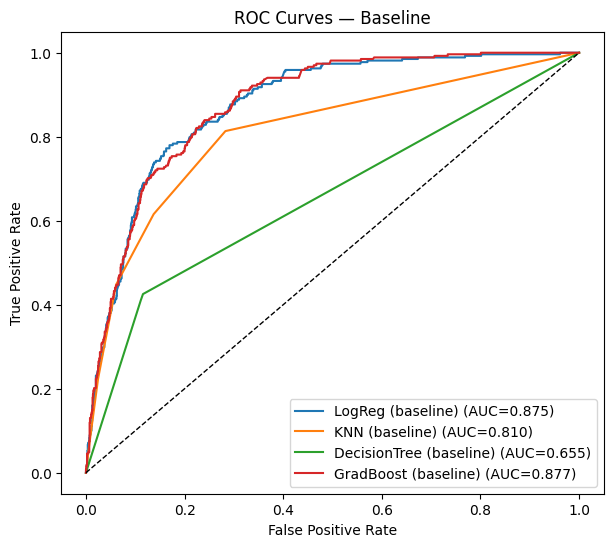

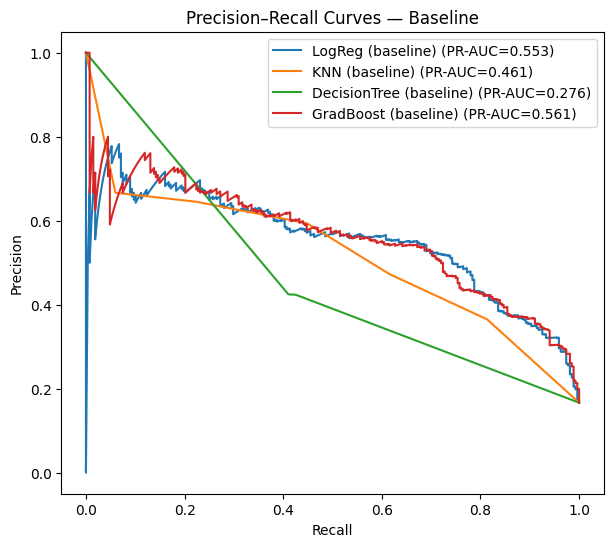

In [18]:
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

pipe_lr_b = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(max_iter=2000, random_state=42))
])

pipe_knn_b = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", KNeighborsClassifier(n_neighbors=5))
])

pipe_tree_b = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("model", DecisionTreeClassifier(random_state=42))
])

pipe_gb_b = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("model", GradientBoostingClassifier(random_state=42))
])

modelos_b = {
    "LogReg (baseline)": pipe_lr_b,
    "KNN (baseline)": pipe_knn_b,
    "DecisionTree (baseline)": pipe_tree_b,
    "GradBoost (baseline)": pipe_gb_b
}

# 5) treinar + métricas + curvas
plt.figure(figsize=(7,6))
for nome, m in modelos_b.items():
    m.fit(X_train_b, y_train_b)
    y_proba = m.predict_proba(X_test_b)[:,1]

    roc = roc_auc_score(y_test_b, y_proba)
    pr  = average_precision_score(y_test_b, y_proba)
    print(f"{nome}  |  ROC-AUC: {roc:.3f}  |  PR-AUC: {pr:.3f}")

    fpr, tpr, _ = roc_curve(y_test_b, y_proba)
    plt.plot(fpr, tpr, label=f"{nome} (AUC={roc:.3f})")

plt.plot([0,1],[0,1],'k--',lw=1)
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curves — Baseline")
plt.legend(); plt.show()

# Precision-Recall curves — baseline
plt.figure(figsize=(7,6))
for nome, m in modelos_b.items():
    y_proba = m.predict_proba(X_test_b)[:,1]
    prec, rec, _ = precision_recall_curve(y_test_b, y_proba)
    pr = average_precision_score(y_test_b, y_proba)
    plt.plot(rec, prec, label=f"{nome} (PR-AUC={pr:.3f})")

plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision–Recall Curves — Baseline")
plt.legend(); plt.show()


# Feature engineering

In [19]:
# === 5) Historical Features (no leakage) ===
df_final_2003_2024 = df_2003_2024.sort_values("data").reset_index(drop=True)

df_final_2003_2024["focos_ultimos_3d"] = (
    df_2003_2024["n_focos"].rolling(3, min_periods=1).sum().shift(1)
)
df_final_2003_2024["focos_ultimos_7d"] = (
    df_2003_2024["n_focos"].rolling(7, min_periods=1).sum().shift(1)
)

if "precipitacao_mm" in df_final_2003_2024.columns:
    df_final_2003_2024["chuva_7d"] = (
        df_final_2003_2024["precipitacao_mm"].rolling(7, min_periods=1).sum().shift(1)
    )
if "temp_media" in df_final_2003_2024.columns:
    df_final_2003_2024["temp_7d"] = (
        df_final_2003_2024["temp_media"].rolling(7, min_periods=1).mean().shift(1)
    )
if "humidade_media" in df_final_2003_2024.columns:
    df_final_2003_2024["humidade_7d"] = (
        df_final_2003_2024["humidade_media"].rolling(7, min_periods=1).mean().shift(1)
    )

# === 6) Variáveis temporais ===
s = pd.to_datetime(df_final_2003_2024["data"])
df_final_2003_2024["mes"] = s.dt.month
df_final_2003_2024["dia_semana"] = s.dt.weekday

df_final_2003_2024.head()

,data,n_focos,target,precipitacao_mm,radiacao_media,temp_media,temp_max,temp_min,temp_orvalho_media,humidade_media,vento_rajada_max,vento_vel_media,focos_ultimos_3d,focos_ultimos_7d,chuva_7d,temp_7d,humidade_7d,mes,dia_semana
0,2003-01-01,0,0,5.4,1123.000000,21.091667,26.0,18.8,18.250000,84.500000,10.1,2.395833,NaN,NaN,NaN,NaN,NaN,1,2
1,2003-01-02,0,0,0.6,1652.214286,22.233333,27.2,18.9,18.033333,78.583333,10.9,2.741667,0.0,0.0,5.4,21.091667,84.500000,1,3
2,2003-01-03,0,0,8.4,1365.285714,21.658333,26.6,18.3,18.266667,81.708333,11.6,3.562500,0.0,0.0,6.0,21.662500,81.541667,1,4
3,2003-01-04,0,0,25.4,1423.785714,21.350000,26.8,17.5,17.716667,81.250000,13.9,4.216667,0.0,0.0,14.4,21.661111,81.597222,1,5
4,2003-01-05,0,0,0.8,1469.846154,21.879167,27.1,17.4,17.162500,75.875000,10.8,4.137500,0.0,0.0,39.8,21.583333,81.510417,1,6


In [20]:
df_final_2003_2024.tail()  # Display the last few rows to check the final DataFrame

,data,n_focos,target,precipitacao_mm,radiacao_media,temp_media,temp_max,temp_min,temp_orvalho_media,humidade_media,vento_rajada_max,vento_vel_media,focos_ultimos_3d,focos_ultimos_7d,chuva_7d,temp_7d,humidade_7d,mes,dia_semana
8031,2024-12-27,0,0,7.8,1551.814286,21.504167,27.3,17.1,18.004167,81.791667,8.2,2.395833,0.0,0.0,79.0,21.327381,85.255952,12,4
8032,2024-12-28,0,0,10.4,1126.785714,22.120833,27.7,18.3,17.483333,77.125000,6.6,1.600000,0.0,0.0,80.8,21.156548,86.172619,12,5
8033,2024-12-29,0,0,19.0,866.421429,20.891667,27.6,17.1,17.245833,81.666667,5.2,1.729167,0.0,0.0,88.0,21.164286,85.339286,12,6
8034,2024-12-30,0,0,2.0,1093.800000,21.108696,26.7,18.0,17.921739,83.434783,12.6,1.969565,0.0,0.0,86.4,21.269643,84.113095,12,0
8035,2024-12-31,0,0,0.0,1233.692857,21.175000,26.7,18.0,17.187500,78.750000,12.1,2.020833,0.0,0.0,81.2,21.221480,83.943064,12,1


In [21]:
df_final_2003_2024.shape

(8036, 19)

In [22]:
# === Quick test to validate if it is not everyhing on 0 ===
dias_com_foco = (df_final_2003_2024["n_focos"] > 0).sum()
total_dias = df_final_2003_2024.shape[0]
perc_dias_com_foco = dias_com_foco / total_dias * 100

print(f"Dias com pelo menos 1 foco: {dias_com_foco} ({perc_dias_com_foco:.2f}%)")
print(f"Dias sem foco: {total_dias - dias_com_foco}")

Dias com pelo menos 1 foco: 1328 (16.53%)
Dias sem foco: 6708


In [86]:
import pandas as pd

# Se o teu dataframe se chama df
df_final_2003_2024["data"] = pd.to_datetime(df_final_2003_2024["data"])

# Selecionar apenas os dias com fogo
fire_days = df_final_2003_2024[df_final_2003_2024["target"] == 1]["data"]

# Calcular diferenças entre dias consecutivos com fogo
intervals = fire_days.diff().dropna()

print("Média de dias entre fogos:", intervals.mean())
print("Mediana de dias entre fogos:", intervals.median())
print("Mínimo intervalo:", intervals.min())
print("Máximo intervalo:", intervals.max())

# Se quiseres ver a distribuição
intervals.value_counts().sort_index()


Média de dias entre fogos: 6 days 00:08:40.874152223
Mediana de dias entre fogos: 2 days 00:00:00
Mínimo intervalo: 1 days 00:00:00
Máximo intervalo: 219 days 00:00:00


data
1 days      505
2 days      388
3 days      103
4 days       69
5 days       56
           ... 
163 days      1
172 days      1
190 days      1
199 days      1
219 days      1
Name: count, Length: 64, dtype: int64

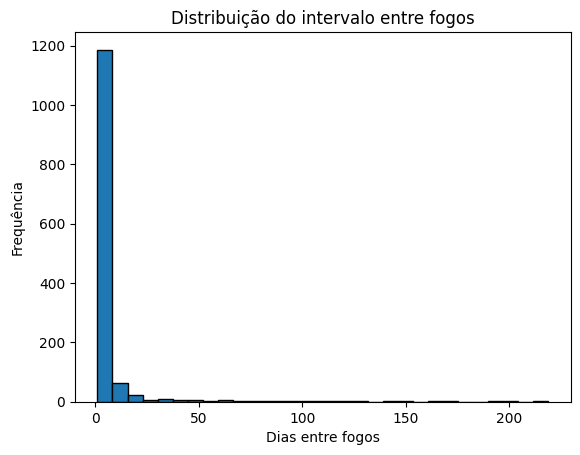

In [87]:
import matplotlib.pyplot as plt

plt.hist(intervals.dt.days, bins=30, edgecolor="black")
plt.xlabel("Dias entre fogos")
plt.ylabel("Frequência")
plt.title("Distribuição do intervalo entre fogos")
plt.show()


With this we can see we have an imbalaced dataset

## 1. Distance

### KNN Classifier (we are using the KNN Classifier because our targer is categorical)

In [23]:
features = [
    'precipitacao_mm', 'temp_media', 'humidade_media', 'chuva_7d', 'temp_7d', 'humidade_7d',
    'focos_ultimos_3d', 'focos_ultimos_7d', 'mes', 'dia_semana'
]

X_fe = df_final_2003_2024[features].fillna(0)
y_fe = df_final_2003_2024["n_focos"]

X_train, X_test, y_train, y_test = train_test_split(X_fe, y_fe, test_size=0.2, random_state=42)

In [24]:
knn_fe = KNeighborsClassifier(n_neighbors=5)
knn_fe.fit(X_train, y_train)

,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [25]:
y_pred_fe = knn_fe.predict(X_test)

In [26]:
# 5) Evaluation
print(confusion_matrix(y_test, y_pred_fe))
print(classification_report(y_test, y_pred_fe))

[[1304   14   11    3    1    3    2    0    0    1    1    0    0    0
     0    0    0    0    0    0]
 [  74    6    3    1    0    1    0    0    0    0    0    0    0    0
     0    0    0    0    0    0]
 [  45    1    1    0    0    0    0    0    0    0    1    0    0    0
     0    0    0    0    0    0]
 [  31    4    0    0    1    0    0    0    0    1    0    0    0    0
     0    0    0    0    0    0]
 [  23    3    1    0    0    0    0    1    0    0    0    0    0    0
     0    0    0    0    0    0]
 [  15    0    2    1    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0]
 [   9    0    1    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0]
 [   4    1    1    0    0    0    0    1    0    0    0    0    0    0
     0    0    0    0    0    0]
 [   7    1    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0]
 [   6    0    0    0    0    0    0    0    0    0    

c:\Users\sofia\anaconda3\envs\Sofia\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\sofia\anaconda3\envs\Sofia\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\sofia\anaconda3\envs\Sofia\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape

## 2. Linear

### Logistic Regression

In [27]:
# Remove rows with NaN in the features
df_lr_fe = df_final_2003_2024.dropna(subset=features + [target]).copy()

X_fe = df_lr_fe[features]
y_fe = df_lr_fe[target]

# === 2) Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_fe, y_fe, test_size=0.2, random_state=42
)

# === 3) Create and train model 
model_ = LogisticRegression()
model_.fit(X_train, y_train)

# === 4) Previsões e avaliação
y_pred_fe = model_.predict(X_test)

print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred_fe))
print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred_fe, digits=2))

=== Confusion Matrix ===
[[1274   70]
 [ 143  111]]

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.90      0.95      0.92      1344
           1       0.61      0.44      0.51       254

    accuracy                           0.87      1598
   macro avg       0.76      0.69      0.72      1598
weighted avg       0.85      0.87      0.86      1598



c:\Users\sofia\anaconda3\envs\Sofia\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## 3. Trees

### **Decision Tree Regression**

*To predict the number of focus (n_focos)*

In [28]:
# Features and target (number of focus)
X_fe = df_final_2003_2024.drop(columns=["data", "n_focos", "target"])
y_fe = df_final_2003_2024["n_focos"]

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X_fe, y_fe, test_size=0.2, random_state=42)

# Model
tree_reg_fe = DecisionTreeRegressor(random_state=42, max_depth=5)
tree_reg_fe.fit(X_train, y_train)

# Predictions
y_pred_fe = tree_reg_fe.predict(X_test)

# Evaluation
print("MAE:", mean_absolute_error(y_test, y_pred_fe))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_fe)))
print("R²:", r2_score(y_test, y_pred_fe))

MAE: 0.7342514145413862
RMSE: 2.042899570171815
R²: 0.16879177453787464


### **Decision Tree Classifier**


*To predict if there will be fire or no (target)*

In [29]:
X_fe = df_final_2003_2024.drop(columns=["data", "n_focos", "target"])
y_fe = df_final_2003_2024["target"]

X_train, X_test, y_train, y_test = train_test_split(X_fe, y_fe, test_size=0.2, random_state=42)

tree_clf_fe = DecisionTreeClassifier(random_state=42, max_depth=5)
tree_clf_fe.fit(X_train, y_train)

y_pred_fe = tree_clf_fe.predict(X_test)

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_fe))
print("\nClassification Report:\n", classification_report(y_test, y_pred_fe))

Confusion Matrix:
 [[1236  104]
 [ 137  131]]

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.92      0.91      1340
           1       0.56      0.49      0.52       268

    accuracy                           0.85      1608
   macro avg       0.73      0.71      0.72      1608
weighted avg       0.84      0.85      0.85      1608



# **4. Boosting models**

### Classifier

In [30]:
# Features e target
X_fe = df_final_2003_2024.drop(columns=["data", "n_focos", "target"])
y_fe = df_final_2003_2024["target"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_fe, y_fe, test_size=0.2, random_state=42)

# === 1) Gradient Boosting (scikit-learn)
hgb_clf_fe = HistGradientBoostingClassifier(random_state=42)
hgb_clf_fe.fit(X_train, y_train)
y_pred_hgb_fe = hgb_clf_fe.predict(X_test)

print("=== Gradient Boosting ===")
print(confusion_matrix(y_test, y_pred_hgb_fe))
print(classification_report(y_test, y_pred_hgb_fe))

# === 2) XGBoost (mais robusto)
xgb_clf_fe = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
xgb_clf_fe.fit(X_train, y_train)
y_pred_xgb_fe = xgb_clf_fe.predict(X_test)

print("=== XGBoost ===")
print(confusion_matrix(y_test, y_pred_xgb_fe))
print(classification_report(y_test, y_pred_xgb_fe))

=== Gradient Boosting ===
[[1250   90]
 [ 144  124]]
              precision    recall  f1-score   support

           0       0.90      0.93      0.91      1340
           1       0.58      0.46      0.51       268

    accuracy                           0.85      1608
   macro avg       0.74      0.70      0.71      1608
weighted avg       0.84      0.85      0.85      1608

=== XGBoost ===
[[1239  101]
 [ 150  118]]
              precision    recall  f1-score   support

           0       0.89      0.92      0.91      1340
           1       0.54      0.44      0.48       268

    accuracy                           0.84      1608
   macro avg       0.72      0.68      0.70      1608
weighted avg       0.83      0.84      0.84      1608



c:\Users\sofia\anaconda3\envs\Sofia\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:44:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


The model that best perfomed was Gradient Boostin, as is predict that 46% of the fires would happen

LogReg (FE)  |  ROC-AUC: 0.878  |  PR-AUC: 0.562
KNN (FE)  |  ROC-AUC: 0.797  |  PR-AUC: 0.408
DecisionTree (FE)  |  ROC-AUC: 0.664  |  PR-AUC: 0.287
GradBoost (FE)  |  ROC-AUC: 0.882  |  PR-AUC: 0.556


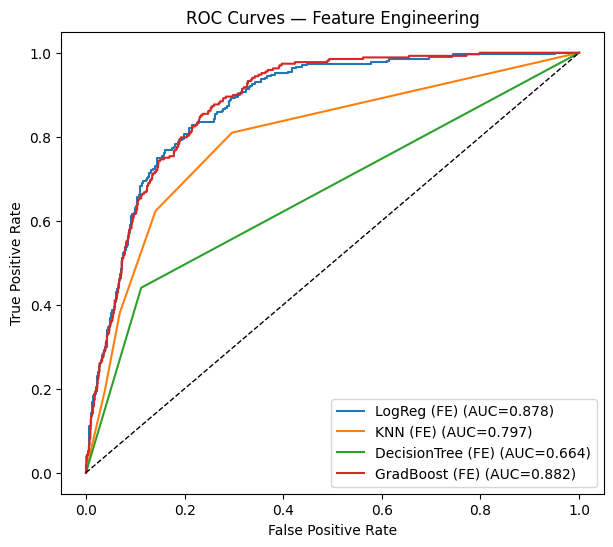

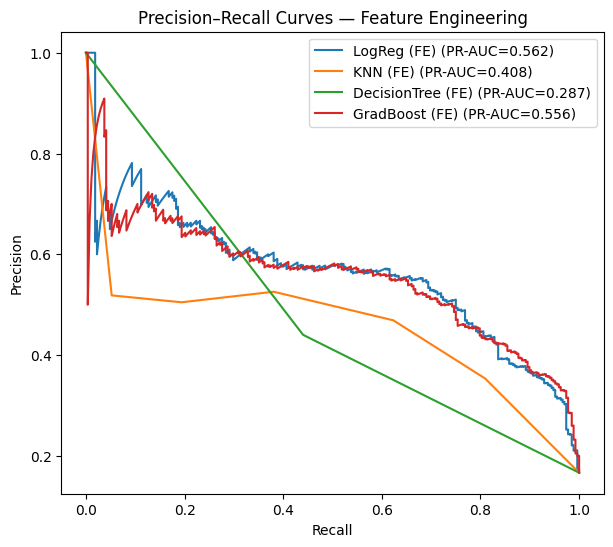

In [31]:
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt

pipe_lr_fe = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(max_iter=2000, random_state=42))
])

pipe_knn_fe = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", KNeighborsClassifier(n_neighbors=5))
])

pipe_tree_fe = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("model", DecisionTreeClassifier(random_state=42))
])

pipe_gb_fe = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("model", GradientBoostingClassifier(random_state=42))
])

modelos_fe = {
    "LogReg (FE)": pipe_lr_fe,
    "KNN (FE)": pipe_knn_fe,
    "DecisionTree (FE)": pipe_tree_fe,
    "GradBoost (FE)": pipe_gb_fe
}

# métricas + curvas ROC — FE
plt.figure(figsize=(7,6))
for nome, m in modelos_fe.items():
    m.fit(X_train, y_train)
    y_proba = m.predict_proba(X_test)[:,1]

    roc = roc_auc_score(y_test, y_proba)
    pr  = average_precision_score(y_test, y_proba)
    print(f"{nome}  |  ROC-AUC: {roc:.3f}  |  PR-AUC: {pr:.3f}")

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{nome} (AUC={roc:.3f})")

plt.plot([0,1],[0,1],'k--',lw=1)
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curves — Feature Engineering")
plt.legend(); plt.show()

# Precision-Recall curves — FE
plt.figure(figsize=(7,6))
for nome, m in modelos_fe.items():
    y_proba = m.predict_proba(X_test)[:,1]
    prec, rec, _ = precision_recall_curve(y_test, y_proba)
    pr = average_precision_score(y_test, y_proba)
    plt.plot(rec, prec, label=f"{nome} (PR-AUC={pr:.3f})")

plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision–Recall Curves — Feature Engineering")
plt.legend(); plt.show()

# **Balance the data**

In [32]:
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

# === Logistic Regression with class_weight ===
log_reg_bal = LogisticRegression(class_weight="balanced", max_iter=1000, random_state=42)
log_reg_bal.fit(X_train, y_train)
y_pred_lr_bal = log_reg_bal.predict(X_test)
print("=== Logistic Regression (balanced) ===")
print(confusion_matrix(y_test, y_pred_lr_bal))
print(classification_report(y_test, y_pred_lr_bal))

=== Logistic Regression (balanced) ===
[[1094  246]
 [  58  210]]
              precision    recall  f1-score   support

           0       0.95      0.82      0.88      1340
           1       0.46      0.78      0.58       268

    accuracy                           0.81      1608
   macro avg       0.71      0.80      0.73      1608
weighted avg       0.87      0.81      0.83      1608



c:\Users\sofia\anaconda3\envs\Sofia\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [33]:
# === Decision Tree with class_weight ===
tree_clf_bal = DecisionTreeClassifier(class_weight="balanced", random_state=42)
tree_clf_bal.fit(X_train, y_train)
y_pred_tree_bal = tree_clf_bal.predict(X_test)
print("\n=== Decision Tree (balanced) ===")
print(confusion_matrix(y_test, y_pred_tree_bal))
print(classification_report(y_test, y_pred_tree_bal))


=== Decision Tree (balanced) ===
[[1202  138]
 [ 147  121]]
              precision    recall  f1-score   support

           0       0.89      0.90      0.89      1340
           1       0.47      0.45      0.46       268

    accuracy                           0.82      1608
   macro avg       0.68      0.67      0.68      1608
weighted avg       0.82      0.82      0.82      1608



In [34]:
#  HistGradientBoostingClassifier (accepts class_weight and NaNs)
from sklearn.ensemble import HistGradientBoostingClassifier

gb_clf_bal = HistGradientBoostingClassifier(class_weight="balanced", random_state=42)
gb_clf_bal.fit(X_train, y_train)
y_pred_gb_bal = gb_clf_bal.predict(X_test)
print("\n=== Gradient Boosting (balanced) ===")
print(confusion_matrix(y_test, y_pred_gb_bal))
print(classification_report(y_test, y_pred_gb_bal))


=== Gradient Boosting (balanced) ===
[[1153  187]
 [  86  182]]
              precision    recall  f1-score   support

           0       0.93      0.86      0.89      1340
           1       0.49      0.68      0.57       268

    accuracy                           0.83      1608
   macro avg       0.71      0.77      0.73      1608
weighted avg       0.86      0.83      0.84      1608



In [35]:
df_ml = df_final_2003_2024[features + [target]].copy()

X = df_ml[features]
y = df_ml[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

A) Class Weight
Logistic Regression com class_weight="balanced"

In [36]:
pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [37]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import classification_report, confusion_matrix

In [38]:

pipe_cw_lr = ImbPipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(class_weight="balanced", max_iter=2000, solver="liblinear", random_state=42)),
])

pipe_cw_lr.fit(X_train, y_train)
y_pred = pipe_cw_lr.predict(X_test)

print("=== Logistic (class_weight) ===")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=2))


=== Logistic (class_weight) ===
[[1060  282]
 [  45  221]]
              precision    recall  f1-score   support

           0       0.96      0.79      0.87      1342
           1       0.44      0.83      0.57       266

    accuracy                           0.80      1608
   macro avg       0.70      0.81      0.72      1608
weighted avg       0.87      0.80      0.82      1608



B) SMOTE (oversampling)


Logistic Regression + SMOTE

In [39]:
pipe_smote_lr = ImbPipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("smote", SMOTE(random_state=42, k_neighbors=5)),
    ("model", LogisticRegression(max_iter=2000, solver="liblinear", random_state=42)),  
])

pipe_smote_lr.fit(X_train, y_train)
y_pred = pipe_smote_lr.predict(X_test)

print("=== Logistic + SMOTE ===")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=3))


=== Logistic + SMOTE ===
[[1064  278]
 [  44  222]]
              precision    recall  f1-score   support

           0      0.960     0.793     0.869      1342
           1      0.444     0.835     0.580       266

    accuracy                          0.800      1608
   macro avg      0.702     0.814     0.724      1608
weighted avg      0.875     0.800     0.821      1608



Classical Gradient Boosting  + SMOTE

In [40]:
pipe_smote_gb = ImbPipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("smote", SMOTE(random_state=42, k_neighbors=5)),
    ("model", GradientBoostingClassifier(random_state=42)),
])

pipe_smote_gb.fit(X_train, y_train)
y_pred = pipe_smote_gb.predict(X_test)

print("=== GradientBoosting + SMOTE ===")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=3))


=== GradientBoosting + SMOTE ===
[[1193  149]
 [  86  180]]
              precision    recall  f1-score   support

           0      0.933     0.889     0.910      1342
           1      0.547     0.677     0.605       266

    accuracy                          0.854      1608
   macro avg      0.740     0.783     0.758      1608
weighted avg      0.869     0.854     0.860      1608



C) Random Oversampling (duplicates  1 examples)

In [41]:
pipe_ros_lr = ImbPipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("ros", RandomOverSampler(random_state=42)),
    ("model", LogisticRegression(max_iter=2000, solver="liblinear", random_state=42)),
])

pipe_ros_lr.fit(X_train, y_train)
y_pred = pipe_ros_lr.predict(X_test)

print("=== Logistic + RandomOverSampler ===")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=3))


=== Logistic + RandomOverSampler ===
[[1056  286]
 [  44  222]]
              precision    recall  f1-score   support

           0      0.960     0.787     0.865      1342
           1      0.437     0.835     0.574       266

    accuracy                          0.795      1608
   macro avg      0.699     0.811     0.719      1608
weighted avg      0.873     0.795     0.817      1608



D) Random Undersampling (extracts 0)

In [42]:
pipe_rus_lr = ImbPipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("rus", RandomUnderSampler(random_state=42)),
    ("model", LogisticRegression(max_iter=2000, solver="liblinear", random_state=42)),
])

pipe_rus_lr.fit(X_train, y_train)
y_pred = pipe_rus_lr.predict(X_test)

print("=== Logistic + RandomUnderSampler ===")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=3))


=== Logistic + RandomUnderSampler ===
[[1065  277]
 [  44  222]]
              precision    recall  f1-score   support

           0      0.960     0.794     0.869      1342
           1      0.445     0.835     0.580       266

    accuracy                          0.800      1608
   macro avg      0.703     0.814     0.725      1608
weighted avg      0.875     0.800     0.821      1608



PR-AUC & ROC-AUC

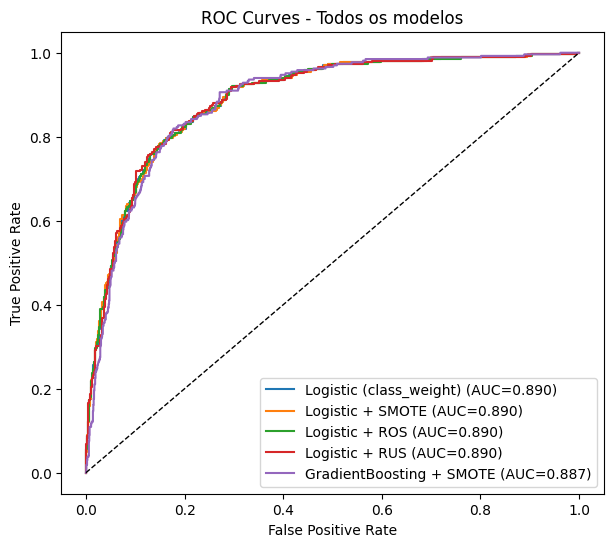

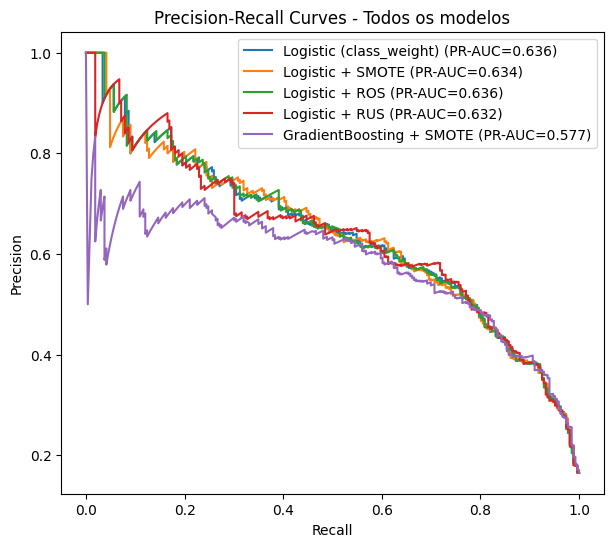

In [43]:
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, roc_curve
import matplotlib.pyplot as plt

# Dictionary to save the trained models
models = {
    "Logistic (class_weight)": pipe_cw_lr,
    "Logistic + SMOTE": pipe_smote_lr,
    "Logistic + ROS": pipe_ros_lr,
    "Logistic + RUS": pipe_rus_lr,
    "GradientBoosting + SMOTE": pipe_smote_gb,
}

# --- ROC Curve ---
plt.figure(figsize=(7,6))
for name, model in models.items():
    y_proba = model.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.3f})")

plt.plot([0,1], [0,1], "k--", lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves - Todos os modelos")
plt.legend()
plt.show()


# --- Precision-Recall Curve ---
plt.figure(figsize=(7,6))
for name, model in models.items():
    y_proba = model.predict_proba(X_test)[:,1]
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, label=f"{name} (PR-AUC={pr_auc:.3f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves - Todos os modelos")
plt.legend()
plt.show()


In [44]:
import pandas as pd
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, precision_recall_curve, auc
)




modelos = {
    "Logistic (class_weight)": pipe_cw_lr,
    "Logistic + SMOTE": pipe_smote_lr,
    "Logistic + ROS": pipe_ros_lr,
    "Logistic + RUS": pipe_rus_lr,
    "GradBoost + SMOTE": pipe_smote_gb,
    # "HistGradBoost (class_weight)": pipe_cw_hgb,   
    "Decision Tree (baseline)": tree_clf,            
    "KNN (baseline)": knn_base,                         
    "Gradient Boosting (baseline)": hgb_clf,       
}

# (Re)treinar tudo neste mesmo split para comparação justa
resultados = []
for name, model in models.items():
    # Treina
    model.fit(X_train, y_train)

    # Predições "duras" 0/1
    y_pred = model.predict(X_test)

    # Probabilidades / scores para AUCs
    try:
        y_score = model.predict_proba(X_test)[:, 1]
    except Exception:
        # Se não tiver predict_proba, tenta decision_function
        y_score = model.decision_function(X_test)

    # Métricas
    acc  = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec  = recall_score(y_test, y_pred, zero_division=0)
    f1   = f1_score(y_test, y_pred, zero_division=0)

    # ROC-AUC (usa y_score contínuo)
    roc  = roc_auc_score(y_test, y_score)

    # PR-AUC (área da curva precisão-recall)
    prec_curve, rec_curve, _ = precision_recall_curve(y_test, y_score)
    pr_auc = auc(rec_curve, prec_curve)

    resultados.append({
        "Model": name,
        "Accuracy": acc,
        "Precision (fire=1)": prec,
        "Recall (fire=1)": rec,
        "F1 (fire=1)": f1,
        "ROC-AUC": roc,
        "PR-AUC": pr_auc
    })

res_df = pd.DataFrame(resultados)\
         .sort_values(["PR-AUC","Recall (fire=1)"], ascending=False)\
         .reset_index(drop=True)


pd.set_option("display.float_format", lambda v: f"{v:.3f}")
res_df


,Model,Accuracy,Precision (fire=1),Recall (fire=1),F1 (fire=1),ROC-AUC,PR-AUC
0,Logistic + ROS,0.795,0.437,0.835,0.574,0.890,0.636
1,Logistic (class_weight),0.797,0.439,0.831,0.575,0.890,0.636
2,Logistic + SMOTE,0.800,0.444,0.835,0.580,0.890,0.634
3,Logistic + RUS,0.800,0.445,0.835,0.580,0.890,0.632
4,GradientBoosting + SMOTE,0.854,0.547,0.677,0.605,0.887,0.577


In [45]:
res_df.to_csv("comparacao_modelos_metricas.csv", index=False)

### **Hyperparametrer tuning**

In [46]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

In [47]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# pipeline base
pipe_lr = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(class_weight="balanced", max_iter=2000, solver="saga", random_state=42))
])

# espaço de pesquisa
param_grid = {
    "logreg__C": [0.01, 0.1, 1, 10],
    "logreg__penalty": ["l1", "l2"]
}

grid_search = GridSearchCV(
    pipe_lr,
    param_grid,
    scoring="average_precision",  # PR-AUC
    cv=5,
    n_jobs=-1
)

# treina
grid_search.fit(X_train, y_train)

print("=== Best Parameters ===")
print(grid_search.best_params_)
print("Best CV Score (PR-AUC):", grid_search.best_score_)

# guarda o modelo tuned
pipe_lr_tuned = grid_search.best_estimator_



=== Best Parameters ===
{'logreg__C': 0.1, 'logreg__penalty': 'l1'}
Best CV Score (PR-AUC): 0.5862099284616523


In [48]:
print("\n=== Test Results ===")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=3))


=== Test Results ===
[[1193  149]
 [  86  180]]
              precision    recall  f1-score   support

           0      0.933     0.889     0.910      1342
           1      0.547     0.677     0.605       266

    accuracy                          0.854      1608
   macro avg      0.740     0.783     0.758      1608
weighted avg      0.869     0.854     0.860      1608



In [49]:
modelos = {
    "LogReg (balanced - default)": pipe_cw_lr,
    "LogReg (balanced - tuned)": pipe_lr_tuned
}

In [52]:
print(grid_search.best_params_)


{'logreg__C': 0.1, 'logreg__penalty': 'l1'}


In [64]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, precision_recall_curve, auc, classification_report, confusion_matrix
)

# ===== 1) Modelo baseline (balanced default) — pipeline limpinho =====
pipe_lr_default = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(class_weight="balanced", max_iter=2000, random_state=42)),
])

pipe_lr_default.fit(X_train, y_train)

# ===== 2) Modelo tuned (resultado do teu GridSearch) =====
# Se já tens o grid feito:
# best_model = grid.best_estimator_
# Caso não, define igual ao melhor que reportaste:
best_model = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(
        class_weight="balanced", max_iter=5000, random_state=42,
        C=0.1, penalty="l1", solver="saga"
    )),
])
best_model.fit(X_train, y_train)

# ===== 3) Funçãozinha interna p/ métricas (sem treinar de novo) =====
def eval_model(model, X_test, y_test):
    y_pred  = model.predict(X_test)
    y_score = model.predict_proba(X_test)[:, 1]
    return {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision (fire=1)": precision_score(y_test, y_pred, zero_division=0),
        "Recall (fire=1)": recall_score(y_test, y_pred, zero_division=0),
        "F1 (fire=1)": f1_score(y_test, y_pred, zero_division=0),
        "ROC-AUC": roc_auc_score(y_test, y_score),
        "PR-AUC": auc(*precision_recall_curve(y_test, y_score)[1::-1])  # auc(recall, precision)
    }, y_pred

# ===== 4) Avaliar ambos
res_default, y_pred_default = eval_model(pipe_lr_default, X_test, y_test)
res_tuned,   y_pred_tuned   = eval_model(best_model,       X_test, y_test)

# ===== 5) Tabela comparativa
res_df = pd.DataFrame([
    {"Model": "LogReg (balanced - default)", **res_default},
    {"Model": "LogReg (balanced - tuned)",   **res_tuned},
]).sort_values(["PR-AUC","Recall (fire=1)"], ascending=False).reset_index(drop=True)

pd.set_option("display.float_format", lambda v: f"{v:.3f}")
print(res_df)

# (Opcional) Confusion matrices para o slide rápido
print("\n=== Confusion Matrix — Default ===")
print(confusion_matrix(y_test, y_pred_default))
print("\n=== Confusion Matrix — Tuned ===")
print(confusion_matrix(y_test, y_pred_tuned))

# (Opcional) guardar em CSV
# res_df.to_csv("comparison_logreg_default_vs_tuned.csv", index=False)


                         Model  Accuracy  Precision (fire=1)  Recall (fire=1)  \
0  LogReg (balanced - default)     0.797               0.439            0.831   
1    LogReg (balanced - tuned)     0.797               0.439            0.831   

   F1 (fire=1)  ROC-AUC  PR-AUC  
0        0.575    0.890   0.636  
1        0.575    0.891   0.633  

=== Confusion Matrix — Default ===
[[1060  282]
 [  45  221]]

=== Confusion Matrix — Tuned ===
[[1060  282]
 [  45  221]]


In [75]:
print("DEFAULT:", pipe_lr_default.get_params()["model"])
print("TUNED  :", best_model.get_params()["model"])


DEFAULT: LogisticRegression(class_weight='balanced', max_iter=2000, random_state=42)
TUNED  : LogisticRegression(C=0.1, class_weight='balanced', max_iter=5000, penalty='l1',
                   random_state=42, solver='saga')


In [76]:
import numpy as np

proba_def = pipe_lr_default.predict_proba(X_test)[:,1]
proba_tun = best_model.predict_proba(X_test)[:,1]

print("Δ probas (média):", np.mean(np.abs(proba_def - proba_tun)))
print("Δ probas (máx):  ", np.max(np.abs(proba_def - proba_tun)))


Δ probas (média): 0.005195271440268311
Δ probas (máx):   0.06619270565045432


In [77]:
from sklearn.metrics import roc_auc_score, average_precision_score

print("ROC-AUC default:", roc_auc_score(y_test, proba_def))
print("PR-AUC  default:", average_precision_score(y_test, proba_def))
print("ROC-AUC tuned  :", roc_auc_score(y_test, proba_tun))
print("PR-AUC  tuned  :", average_precision_score(y_test, proba_tun))


ROC-AUC default: 0.8903527447530899
PR-AUC  default: 0.636721094626722
ROC-AUC tuned  : 0.8907029122732316
PR-AUC  tuned  : 0.6342560063909902


In [78]:
from sklearn.metrics import f1_score, recall_score, precision_score

def eval_at(th, proba, y_true):
    y_hat = (proba >= th).astype(int)
    return dict(
        threshold=th,
        precision=precision_score(y_true, y_hat, zero_division=0),
        recall=recall_score(y_true, y_hat, zero_division=0),
        f1=f1_score(y_true, y_hat, zero_division=0)
    )

for th in [0.3, 0.4, 0.5, 0.6]:
    m_def = eval_at(th, proba_def, y_test)
    m_tun = eval_at(th, proba_tun, y_test)
    print(f"[th={th}]  DEFAULT  -> P:{m_def['precision']:.3f} R:{m_def['recall']:.3f} F1:{m_def['f1']:.3f}")
    print(f"[th={th}]  TUNED    -> P:{m_tun['precision']:.3f} R:{m_tun['recall']:.3f} F1:{m_tun['f1']:.3f}")


[th=0.3]  DEFAULT  -> P:0.346 R:0.929 F1:0.505
[th=0.3]  TUNED    -> P:0.347 R:0.929 F1:0.505
[th=0.4]  DEFAULT  -> P:0.384 R:0.887 F1:0.536
[th=0.4]  TUNED    -> P:0.383 R:0.883 F1:0.534
[th=0.5]  DEFAULT  -> P:0.439 R:0.831 F1:0.575
[th=0.5]  TUNED    -> P:0.439 R:0.831 F1:0.575
[th=0.6]  DEFAULT  -> P:0.499 R:0.793 F1:0.612
[th=0.6]  TUNED    -> P:0.499 R:0.789 F1:0.611


# **Final Prediction**

In [79]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression


# Features used in train
features = ["precipitacao_mm", "radiacao_media", "temp_media", 
            "temp_max", "temp_min", "humidade_media", 
            "vento_rajada_max", "vento_vel_media",
            "focos_ultimos_3d", "focos_ultimos_7d",
            "chuva_7d", "temp_7d", "humidade_7d",
            "mes", "dia_semana"]

target = "target"

X_all = df_final_2003_2024[features]
y_all = df_final_2003_2024[target]

# === 1) Treinar o modelo final com TODO o histórico 2003–2024 ===
final_model = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(class_weight="balanced", max_iter=2000, random_state=42))
])

X_all = df_final_2003_2024[features]
y_all = df_final_2003_2024[target]

final_model.fit(X_all, y_all)

# === 2) Simulação de previsão final: últimos 7 dias de 2024 ===
df_novo = df_final_2003_2024.copy()

y_pred_proba = final_model.predict_proba(df_novo[features])[:, 1]
y_pred_class = final_model.predict(df_novo[features])

df_novo["fire_probability"] = y_pred_proba
df_novo["fire_prediction"] = y_pred_class

# Mostrar só as colunas relevantes
print(df_novo[["data", "fire_probability", "fire_prediction"]])


           data  fire_probability  fire_prediction
0    2003-01-01             0.058                0
1    2003-01-02             0.086                0
2    2003-01-03             0.082                0
3    2003-01-04             0.085                0
4    2003-01-05             0.143                0
...         ...               ...              ...
8031 2024-12-27             0.030                0
8032 2024-12-28             0.028                0
8033 2024-12-29             0.031                0
8034 2024-12-30             0.015                0
8035 2024-12-31             0.024                0

[8036 rows x 3 columns]


In [80]:
df_novo[["data", "fire_probability", "fire_prediction"]].to_csv(
    "final_predictions_2024.csv", index=False
)

print("✅ Ficheiro salvo: final_predictions_2024.csv")

✅ Ficheiro salvo: final_predictions_2024.csv


# 2025 prediction

In [81]:
climate_data_2025 = pd.read_csv(r"C:\Users\sofia\Documents\Data_Analytics_Ironhack\Projects\google_brain\Climate_data\INMET_CO_DF_A001_BRASILIA_01-01-2025_A_31-07-2025.CSV",
                                skiprows=8,
                                sep=";",         
                                encoding="latin1")

climate_data_2025.head()

,Data,Hora UTC,"PRECIPITAÇÃO TOTAL, HORÁRIO (mm)","PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)",PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB),PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB),RADIACAO GLOBAL (Kj/m²),"TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)",TEMPERATURA DO PONTO DE ORVALHO (°C),TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C),TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C),TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C),TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C),UMIDADE REL. MAX. NA HORA ANT. (AUT) (%),UMIDADE REL. MIN. NA HORA ANT. (AUT) (%),"UMIDADE RELATIVA DO AR, HORARIA (%)","VENTO, DIREÇÃO HORARIA (gr) (° (gr))","VENTO, RAJADA MAXIMA (m/s)","VENTO, VELOCIDADE HORARIA (m/s)",Unnamed: 19
0,2025/01/01,0000 UTC,0,"886,1","886,1","885,5",NaN,"20,8","19,5","20,9","20,7","19,5","19,2",92.000,90.000,92.000,8.000,"3,6","1,8",NaN
1,2025/01/01,0100 UTC,0,"886,3","886,4",886,NaN,"20,7","19,3","20,8","20,5","19,5","19,3",93.000,92.000,92.000,4.000,"3,4","1,9",NaN
2,2025/01/01,0200 UTC,0,"886,7","886,7","886,2",NaN,"20,6","19,1","20,8","20,5","19,3",19,92.000,91.000,91.000,3.000,"3,7","1,4",NaN
3,2025/01/01,0300 UTC,0,"886,4","886,7","886,4",NaN,"20,3","18,9","20,6","20,1","19,1","18,7",92.000,91.000,92.000,345.000,3,"1,1",NaN
4,2025/01/01,0400 UTC,0,"885,9","886,4","885,9",NaN,"19,8","18,9","20,3","19,7","19,1","18,8",95.000,92.000,94.000,228.000,2,",3",NaN


In [82]:
climate_data_2025['Data'] = pd.to_datetime(climate_data_2025['Data'], format="%Y/%m/%d", errors='coerce')

for col in climate_data_2025.columns[2:]: #starting on the third column
    climate_data_2025[col] = (
        climate_data_2025[col].astype(str)
        .str.replace(",", ".")
        .str.strip()
        .replace("", "0")
        .astype(float)
    )

meteo_daily_2025 = climate_data_2025.groupby('Data').agg({
    'PRECIPITAÇÃO TOTAL, HORÁRIO (mm)': 'sum',
    'RADIACAO GLOBAL (Kj/m²)': 'mean',
    'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)': 'mean',
    'TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)': 'max',
    'TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)': 'min',
    'TEMPERATURA DO PONTO DE ORVALHO (°C)': 'mean',
    'UMIDADE RELATIVA DO AR, HORARIA (%)': 'mean',
    'VENTO, RAJADA MAXIMA (m/s)': 'max',
    'VENTO, VELOCIDADE HORARIA (m/s)': 'mean'
}).reset_index()


meteo_daily_2025.rename(columns={
    'PRECIPITAÇÃO TOTAL, HORÁRIO (mm)': 'precipitacao_mm',
    'RADIACAO GLOBAL (Kj/m²)': 'radiacao_media',
    'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)': 'temp_media',
    'TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)': 'temp_max',
    'TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)': 'temp_min',
    'TEMPERATURA DO PONTO DE ORVALHO (°C)': 'temp_orvalho_media',
    'UMIDADE RELATIVA DO AR, HORARIA (%)': 'humidade_media',
    'VENTO, RAJADA MAXIMA (m/s)': 'vento_rajada_max',
    'VENTO, VELOCIDADE HORARIA (m/s)': 'vento_vel_media'
}, inplace=True)

meteo_daily_2025.head()

,Data,precipitacao_mm,radiacao_media,temp_media,temp_max,temp_min,temp_orvalho_media,humidade_media,vento_rajada_max,vento_vel_media
0,2025-01-01,0.000,870.964,21.150,24.800,18.800,18.908,87.417,9.700,1.658
1,2025-01-02,0.000,1523.831,22.304,28.200,18.800,17.613,76.625,8.300,2.146
2,2025-01-03,0.000,1853.800,22.900,29.400,18.000,17.517,73.833,8.100,2.025
3,2025-01-04,0.000,1436.531,23.346,30.100,19.600,17.358,71.167,8.600,1.662
4,2025-01-05,1.600,1021.907,21.938,28.900,18.300,18.588,82.500,8.400,1.696


In [83]:
# === 5) Historical Features (no leakage) ===
df_final_2025 = meteo_daily_2025.sort_values("Data").reset_index(drop=True)


if "precipitacao_mm" in df_final_2025.columns:
    df_final_2025["chuva_7d"] = (
        df_final_2025["precipitacao_mm"].rolling(7, min_periods=1).sum().shift(1)
    )
if "temp_media" in df_final_2025.columns:
    df_final_2025["temp_7d"] = (
        df_final_2025["temp_media"].rolling(7, min_periods=1).mean().shift(1)
    )
if "humidade_media" in df_final_2025.columns:
    df_final_2025["humidade_7d"] = (
        df_final_2025["humidade_media"].rolling(7, min_periods=1).mean().shift(1)
    )

# === 6) Variáveis temporais ===
s = pd.to_datetime(df_final_2025["Data"])
df_final_2025["mes"] = s.dt.month
df_final_2025["dia_semana"] = s.dt.weekday

df_final_2025.head()

,Data,precipitacao_mm,radiacao_media,temp_media,temp_max,temp_min,temp_orvalho_media,humidade_media,vento_rajada_max,vento_vel_media,chuva_7d,temp_7d,humidade_7d,mes,dia_semana
0,2025-01-01,0.000,870.964,21.150,24.800,18.800,18.908,87.417,9.700,1.658,NaN,NaN,NaN,1,2
1,2025-01-02,0.000,1523.831,22.304,28.200,18.800,17.613,76.625,8.300,2.146,0.000,21.150,87.417,1,3
2,2025-01-03,0.000,1853.800,22.900,29.400,18.000,17.517,73.833,8.100,2.025,0.000,21.727,82.021,1,4
3,2025-01-04,0.000,1436.531,23.346,30.100,19.600,17.358,71.167,8.600,1.662,0.000,22.118,79.292,1,5
4,2025-01-05,1.600,1021.907,21.938,28.900,18.300,18.588,82.500,8.400,1.696,0.000,22.425,77.260,1,6


In [84]:
# 1) features que existem tanto em 2003–2024 como em 2025
deploy_features = [
    "precipitacao_mm","radiacao_media","temp_media","temp_max","temp_min",
    "humidade_media","vento_rajada_max","vento_vel_media",
    "chuva_7d","temp_7d","humidade_7d","mes","dia_semana"   # <-- mantém lags meteo, tira focos_*
]
target = "target"

# 2) treinar o modelo de deploy com dados 2003–2024
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

X_deploy_train = df_final_2003_2024[deploy_features]
y_deploy_train = df_final_2003_2024[target]

deploy_model = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(class_weight="balanced", max_iter=2000, random_state=42))
])
deploy_model.fit(X_deploy_train, y_deploy_train)

# 3) garantir que o df_final_2025 tem as MESMAS colunas (criar se faltar)
for col in deploy_features:
    if col not in df_final_2025.columns:
        df_final_2025[col] = 0  # fallback seguro; ideal é calcular corretamente as três lags meteo e tempo

# 4) prever 2025
X_2025 = df_final_2025[deploy_features]
preds_2025 = df_final_2025.copy()
preds_2025["fire_probability"] = deploy_model.predict_proba(X_2025)[:, 1]
preds_2025["fire_prediction"]  = deploy_model.predict(X_2025)

preds_2025[["Data","fire_probability","fire_prediction"]].to_csv("predictions_2025.csv", index=False)
print("✅ Guardado: predictions_2025.csv")


✅ Guardado: predictions_2025.csv


In [91]:
preds_2025.head()

,Data,precipitacao_mm,radiacao_media,temp_media,temp_max,temp_min,temp_orvalho_media,humidade_media,vento_rajada_max,vento_vel_media,chuva_7d,temp_7d,humidade_7d,mes,dia_semana,fire_probability,fire_prediction
0,2025-01-01,0.000,870.964,21.150,24.800,18.800,18.908,87.417,9.700,1.658,NaN,NaN,NaN,1,2,0.025,0
1,2025-01-02,0.000,1523.831,22.304,28.200,18.800,17.613,76.625,8.300,2.146,0.000,21.150,87.417,1,3,0.098,0
2,2025-01-03,0.000,1853.800,22.900,29.400,18.000,17.517,73.833,8.100,2.025,0.000,21.727,82.021,1,4,0.137,0
3,2025-01-04,0.000,1436.531,23.346,30.100,19.600,17.358,71.167,8.600,1.662,0.000,22.118,79.292,1,5,0.136,0
4,2025-01-05,1.600,1021.907,21.938,28.900,18.300,18.588,82.500,8.400,1.696,0.000,22.425,77.260,1,6,0.071,0


In [92]:
preds_2025.to_csv("predictions_2025_full.csv", index=False)
print("✅ Guardado: predictions_2025_full.csv")

✅ Guardado: predictions_2025_full.csv


In [93]:
preds_2025[["Data","precipitacao_mm","radiacao_media","temp_media","temp_max","temp_min",
            "humidade_media","vento_rajada_max","vento_vel_media",]].to_csv("teste_2025.csv", index=False)

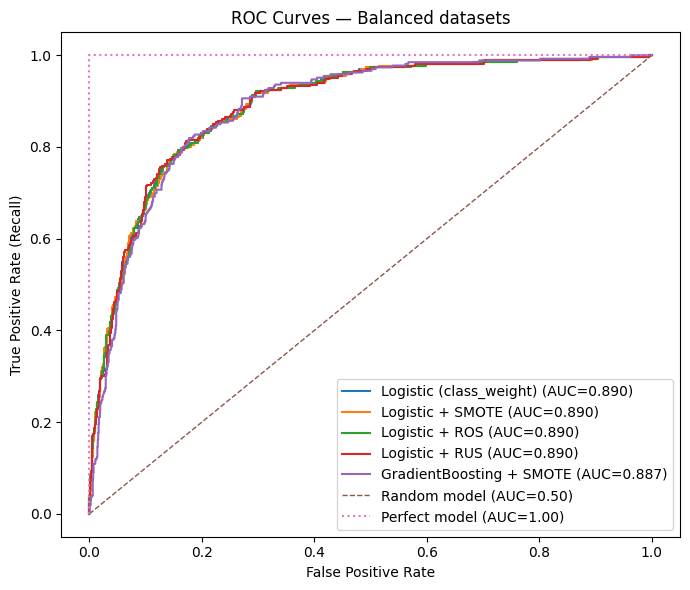

In [85]:
# ===== ROC CURVES (balanced) com referências "random" e "perfect" =====
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Ex.: models_bal = {"Logistic (class_weight)": pipe_cw_lr, "ROS + Logistic": pipe_ros_lr, ...}

plt.figure(figsize=(7,6))

for name, model in models.items():
    # probabilidades da classe 1
    try:
        y_score = model.predict_proba(X_test)[:, 1]
    except Exception:
        y_score = model.decision_function(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_score)
    auc_val = roc_auc_score(y_test, y_score)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc_val:.3f})")

# referência: modelo aleatório (AUC=0.5)
plt.plot([0,1], [0,1], linestyle="--", linewidth=1, label="Random model (AUC=0.50)")

# referência: modelo perfeito (AUC=1.0)
plt.plot([0,0,1], [0,1,1], linestyle=":", linewidth=1.5, label="Perfect model (AUC=1.00)")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curves — Balanced datasets")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


In [94]:
import joblib
joblib.dump(deploy_model, "modelo_brasilia.pkl")



['modelo_brasilia.pkl']